<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/fruit-single-shot-detection/notebooks/fruit-single-shot-detection/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fruit single shot detector

## 0. Imports and global functions.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import tensorflow as tf
import xml.etree.ElementTree as ET
from google.colab import auth
from googleapiclient.discovery import build
from google.colab import userdata

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os
from tensorflow.keras.models import load_model



# Request permissions to access (read/write) the Google Drive Folder ID
GOOGLE_DRIVE_FOLDER_ID = "14LvaZfifLwoGsnIbwINaEZMSLEpP4E4-"
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 1. Función para guardar en Google Drive
def save_model_to_drive(model_obj, filename):
    # Primero guardamos localmente
    local_path = f"/content/{filename}"
    model_obj.save(local_path)
    print(f"Modelo guardado localmente en {local_path}")

    # Metadatos para Drive
    file_metadata = {
        'name': filename,
        'parents': [GOOGLE_DRIVE_FOLDER_ID]
    }

    media = MediaFileUpload(local_path, mimetype='application/octet-stream')

    # Subir
    print("Subiendo a Google Drive...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

    print(f"Modelo subido con ID: {file.get('id')}")

## 1. Download dataset.

In [2]:

KAGGLE_DATASET = "mbkinaci/fruit-images-for-object-detection"
BASE_DIR = "/content/fruit_data"
MODEL_TO_LOAD = "fruit_detector_v2.keras"
MODEL_TO_SAVE = "fruit_detector_v4.keras"

# Configurar Kaggle
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
if not os.path.exists(BASE_DIR):
    print("Download dataset...")
    !kaggle datasets download -d {KAGGLE_DATASET}
    !unzip -q fruit-images-for-object-detection.zip -d {BASE_DIR}
    print(f"Dataset download in {BASE_DIR}")
else:
    print("The dataset has been already downloaded.")

# Verificar estructura
print("Dataset Folders:", os.listdir(BASE_DIR))

Download dataset...
Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 621MB/s]
Dataset download in /content/fruit_data
Dataset Folders: ['test_zip', 'train_zip']


## 3. Pre-processing
Regroup the dataset annotations so that each unique image is associated with all its bounding boxes and labels, eliminating the duplicate image entries found in the current variables. You should re-process the data from /content/fruit_data or restructure the existing arrays.

After grouping, implement a Target Encoder to map the variable-length ground truth boxes to a fixed-size grid tensor (e.g., 7x7). This encoder should assign objects to grid cells based on their center coordinates (similar to YOLO or simplified SSD), creating the target tensors required for training.

## 3.1 Encode features

In [3]:
# Parámetros
GRID_SIZE = 7
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Mapeo de Clases
CLASS_MAP = {"apple": 0, "banana": 1, "orange": 2}
INV_CLASS_MAP = {0: "apple", 1: "banana", 2: "orange"}

# Get image shape
def get_image_dimensions(img_path):
    try:
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            return width, height
        else:
            print(f"Error: The image could not be loaded from the path: {img_path}")
            return None, None
    except Exception as e:
        print(f"Error trying to read the image: {img_path}: {e}")
        return None, None

# Load the datasets
def load_grouped_data(directory):
    images = []
    all_annotations = []

    # Iterate through all files in the directory
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image path
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                  print(f"Image not found: {img_path}")
                  continue

                # Get original dimensions
                size = root.find("size")
                # many of the xml files were setting with width=0, height=0
                # w_orig = int(size.find("width").text)
                # h_orig = int(size.find("height").text)
                w_orig, h_orig = get_image_dimensions(os.path.join(directory, filename))


                # Find all valid objects
                objects = root.findall("object")
                img_boxes = []

                for obj in objects:
                    name = obj.find("name").text
                    if name in CLASS_MAP:
                        label = CLASS_MAP[name]
                        bndbox = obj.find("bndbox")
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)


                        # Store as [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label] for now
                        # Actually, keeping min/max for flexibility or converting to center/size directly?
                        # The instructions say "Normalize the bounding box coordinates to [0, 1]"
                        # Let's store [xmin/w, ymin/h, xmax/w, ymax/h, label]
                        img_boxes.append([
                            xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label
                        ])

                if img_boxes:
                    # Load and resize image
                    try:
                        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                        img_arr = img_to_array(img) / 255.0
                        images.append(img_arr)
                        all_annotations.append(img_boxes)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype="float32"), all_annotations


print("Reloading Train Data...")
X_train, train_bboxes = load_grouped_data(os.path.join(BASE_DIR, "train_zip", "train"))

print("Reloading Test Data...")
X_test, test_bboxes = load_grouped_data(os.path.join(BASE_DIR, "test_zip", "test"))

print(f"Grouped X_train shape: {X_train.shape}")
print(f"Grouped X_test shape: {X_test.shape}")

Reloading Train Data...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Reloading Test Data...
Grouped X_train shape: (240, 224, 224, 3)
Grouped X_test shape: (60, 224, 224, 3)


## 3.2 Encode labels


- Frame the image in a 7 x 7 grid
- Get the SSD/YOLO cordenates confidence, centerX, centerY, width , height, one hot encode of the class [apple, banana, orange]


**Tensor Population:**

    *   At the calculated `[row, col]` index, it fills the depth vector `[8]` with:

        *   **Index 0:** Confidence = `1.0` (Object Present).
        *   **Index 1-4:** Coordinates `[cx, cy, w, h]`.
        *   **Index 5-7:** One-hot encoded Class Label (e.g., `[1, 0, 0]` for Apple).


**Output Vector Structure:**

`[ Confidence, cx, cy, w, h, Class0, Class1, Class2 ]`

In [114]:
# Target Encoder for SSD/YOLO style grid
def encode_target(bboxes_list, grid_size=GRID_SIZE, num_classes=3):
    # Output: (7, 7, 8) -> [confidence, cx, cy, w, h, c0, c1, c2]
    target = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in bboxes_list:
        xmin, ymin, xmax, ymax, label = box

        # Calculate Center and Size (normalized global)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin

        # Determine grid cell
        col = int(cx * grid_size)
        row = int(cy * grid_size)

        # Boundary check
        col = min(col, grid_size - 1)
        row = min(row, grid_size - 1)

        # Populate tensor if empty (or overwrite)
        # We set confidence to 1
        if target[row, col, 0] == 0:
            target[row, col, 0] = 1.0
            target[row, col, 1:5] = [cx, cy, w, h]
            target[row, col, 5 + int(label)] = 1.0

    return target

# Apply encoder
print("Encoding targets...")
y_train = np.array([encode_target(bboxes) for bboxes in train_bboxes])
y_test = np.array([encode_target(bboxes) for bboxes in test_bboxes])

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Encoding targets...
y_train shape: (240, 7, 7, 8)
y_test shape: (60, 7, 7, 8)


## 3.3 Visualize pre-processed datasets

Visualizing index: 35 from Train dataset...


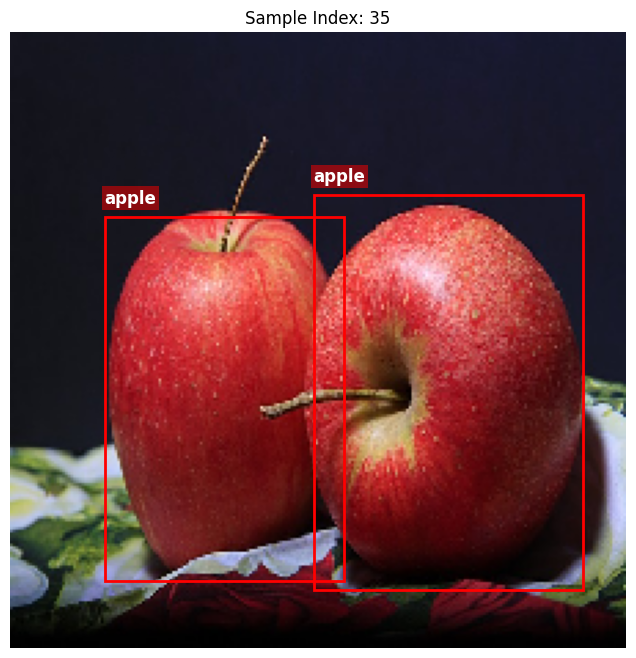

In [115]:
def visualize_dataset_sample(images, annotations, index):
    """
    Visualizes an image from the dataset with its corresponding bounding boxes and class labels.

    Args:
        images (numpy.array): The array of images (normalized 0-1).
        annotations (list): List of lists containing bounding boxes and labels.
                            Format: [[xmin, ymin, xmax, ymax, label], ...]
        index (int): The index of the image to visualize.
    """
    # 1. Retrieve image and annotations
    try:
        img = images[index]
        boxes = annotations[index]
    except IndexError:
        print(f"Error: Index {index} is out of bounds.")
        return

    # 2. Create plot
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # Display the image
    # The input images are already normalized to [0, 1] based on your load_grouped_data function
    ax.imshow(img)

    # 3. Draw bounding boxes
    img_h, img_w, _ = img.shape

    if len(boxes) == 0:
        print("No objects labeled in this image.")

    for box in boxes:
        # Extract normalized coordinates and label
        # Your format: [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label]
        xmin_n, ymin_n, xmax_n, ymax_n, label_idx = box

        # Denormalize coordinates to pixel values
        xmin = xmin_n * img_w
        ymin = ymin_n * img_h
        xmax = xmax_n * img_w
        ymax = ymax_n * img_h

        # Calculate width and height for the Rectangle patch
        width = xmax - xmin
        height = ymax - ymin

        # Get class name
        class_name = INV_CLASS_MAP.get(int(label_idx), "Unknown")

        # Create a Rectangle patch
        # (xy) is the bottom-left point usually, but in image coords (0,0 is top-left),
        # xy is the top-left corner of the rect.
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )

        # Add the patch to the Axes
        ax.add_patch(rect)

        # 4. Add Label Text
        # We place a background box behind text for better readability
        plt.text(
            xmin,
            ymin - 5, # Slightly above the box
            class_name,
            color='white',
            fontsize=12,
            weight='bold',
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none', pad=2)
        )

    # Final cleanup
    plt.axis('off') # Hide axes ticks
    plt.title(f"Sample Index: {index}")
    plt.show()


# Select dataset to visualize (Change to X_test/test_bboxes if desired)
target_images = X_train
target_bboxes = train_bboxes

# Calculate a random index between 0 and the maximum index
random_index = random.randint(0, len(target_images) - 1)

print(f"Visualizing index: {random_index} from Train dataset...")

# Call the visualization function
visualize_dataset_sample(target_images, target_bboxes, random_index)